In [2]:
!pip install dask[dataframe] seaborn boto3 s3fs  # Install dependencies in SageMaker
import boto3
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import gc

In [3]:
# S3 Configuration
s3_client = boto3.client("s3")
bucket_name = "melissafinalbucket"


In [4]:
# S3 File Paths
file_keys = {
    "Production": "prod_csv/prod_flight_data.csv",
    "Test": "test_csv/test_flight_data.csv",
    "Training": "train_csv/training_flight_data.csv",
    "Validation": "valid_csv/valid_flight_data.csv"
}

In [5]:
# Load CSV using Pandas (for small/medium data)
def load_csv_pandas(bucket, file_key, chunksize=10000):
    response = s3_client.get_object(Bucket=bucket, Key=file_key)
    return pd.concat(pd.read_csv(io.BytesIO(response["Body"].read()), chunksize=chunksize), ignore_index=True)

# Load CSV using Dask (for large data)
def load_csv_dask(bucket, file_key):
    s3_path = f"s3://{bucket}/{file_key}"
    return dd.read_csv(s3_path, storage_options={"anon": False})  # Requires S3 permissions

# Use Dask for Large Data, Pandas for Small
use_dask = True  # Set to False if data is small


In [6]:
# Load Data
dfs = {}
for name, file_key in file_keys.items():
    print(f" Loading {name} dataset...")  
    dfs[name] = load_csv_dask(bucket_name, file_key) if use_dask else load_csv_pandas(bucket_name, file_key)

 Loading Production dataset...


/opt/conda/lib/python3.11/site-packages/fsspec/registry.py:279: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


 Loading Test dataset...
 Loading Training dataset...
 Loading Validation dataset...


In [10]:
# Perform EDA
for name, df in dfs.items():
    print(f"\n EDA for {name} Dataset:\n")

    # Dataset Shape (Fixed for Dask)
    print(f"Shape: {df.shape if not use_dask else (df.shape[0].compute(), df.shape[1])}")

    # Data Types (Fixed for Dask)
    print(f"Data Types:\n{df.dtypes if not use_dask else df.dtypes}")

    # Missing Values (Fixed for Dask)
    print(f"Missing Values:\n{df.isnull().sum().compute() if use_dask else df.isnull().sum()}")

    # Unique Label Values
    unique_labels = df["Label"].unique()
    print(f"Unique Label Values: {unique_labels.compute() if use_dask and isinstance(unique_labels, dd.Series) else unique_labels}")

    # Convert TimeStep to Float (if not already)
    if not use_dask:
        df["TimeStep"] = df["TimeStep"].astype(str).astype(float)

    # Plot Feature Distributions (Pandas Only)
    if not use_dask:
        plt.figure(figsize=(12, 6))
        num_features = [col for col in df.columns if "Feature" in col]
        for i, feature in enumerate(num_features[:6]):  # First 6 features
            plt.subplot(2, 3, i + 1)
            sns.histplot(df[feature], bins=30, kde=True)
            plt.title(f"Distribution of {feature}")
        plt.tight_layout()
        plt.show()

    # Free Memory
    del df
    gc.collect()

print("\n EDA Completed Successfully!")


 EDA for Production Dataset:

Shape: (6363840, 23)
Data Types:
SampleID        int64
TimeStep        int64
Feature_0     float64
Feature_1     float64
Feature_2     float64
Feature_3     float64
Feature_4     float64
Feature_5     float64
Feature_6     float64
Feature_7     float64
Feature_8     float64
Feature_9     float64
Feature_10    float64
Feature_11    float64
Feature_12    float64
Feature_13    float64
Feature_14    float64
Feature_15    float64
Feature_16    float64
Feature_17    float64
Feature_18    float64
Feature_19    float64
Label         float64
dtype: object
Missing Values:
SampleID      0
TimeStep      0
Feature_0     0
Feature_1     0
Feature_2     0
Feature_3     0
Feature_4     0
Feature_5     0
Feature_6     0
Feature_7     0
Feature_8     0
Feature_9     0
Feature_10    0
Feature_11    0
Feature_12    0
Feature_13    0
Feature_14    0
Feature_15    0
Feature_16    0
Feature_17    0
Feature_18    0
Feature_19    0
Label         0
dtype: int64
Unique Label Values

In [ ]:
# EDA with Visualizations
for name, df in dfs.items():
    print(f"\n EDA for {name} Dataset:\n")

    # Dataset Shape
    print(f"Shape: {df.shape}")

    # Data Types
    print(f"Data Types:\n{df.dtypes}")

    # Missing Values
    print(f"Missing Values:\n{df.isnull().sum()}")

    # Unique Label Values
    print(f"Unique Label Values:\n{df['Label'].unique()}")

    # Convert TimeStep to Float
    df["TimeStep"] = df["TimeStep"].astype(float)

    #  Feature Distribution Plots
    plt.figure(figsize=(12, 6))
    num_features = [col for col in df.columns if "Feature" in col]
    
    for i, feature in enumerate(num_features[:6]):  # First 6 features
        plt.subplot(2, 3, i + 1)
        sns.histplot(df[feature], bins=30, kde=True)
        plt.title(f"Distribution of {feature}")
    
    plt.tight_layout()
    plt.show()

    # Boxplots to Identify Outliers
    plt.figure(figsize=(12, 6))
    for i, feature in enumerate(num_features[:6]):  # First 6 features
        plt.subplot(2, 3, i + 1)
        sns.boxplot(y=df[feature])
        plt.title(f"Boxplot of {feature}")
    
    plt.tight_layout()
    plt.show()

    # Heatmap of Feature Correlations
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[num_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.show()

    # Pairplot of Selected Features
    selected_features = num_features[:4] + ["Label"]  # Select first 4 features and label
    sns.pairplot(df[selected_features], hue="Label", diag_kind="kde")
    plt.show()

    # Free Memory
    del df
    gc.collect()

print("\n EDA Completed Successfully!")


 EDA for Production Dataset:

 Shape: (<dask_expr.expr.Scalar: expr=Assign(frame=ArrowStringConversion(frame=FromMapProjectable(a0d51ef))).size() // 23, dtype=int64>, 23)
 Data Types:
SampleID        int64
TimeStep      float64
Feature_0     float64
Feature_1     float64
Feature_2     float64
Feature_3     float64
Feature_4     float64
Feature_5     float64
Feature_6     float64
Feature_7     float64
Feature_8     float64
Feature_9     float64
Feature_10    float64
Feature_11    float64
Feature_12    float64
Feature_13    float64
Feature_14    float64
Feature_15    float64
Feature_16    float64
Feature_17    float64
Feature_18    float64
Feature_19    float64
Label         float64
dtype: object
 Missing Values:
Dask Series Structure:
npartitions=1
Feature_0    int64
TimeStep       ...
Dask Name: sum, 8 expressions
Expr=(~ NotNull(frame=Assign(frame=ArrowStringConversion(frame=FromMapProjectable(a0d51ef))))).sum()
 Unique Label Values:
Dask Series Structure:
npartitions=23
    float64


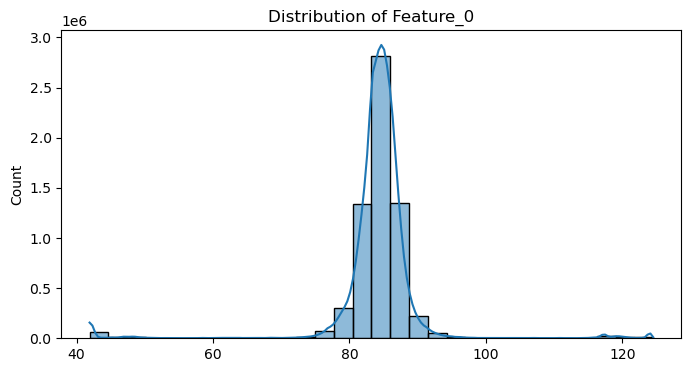

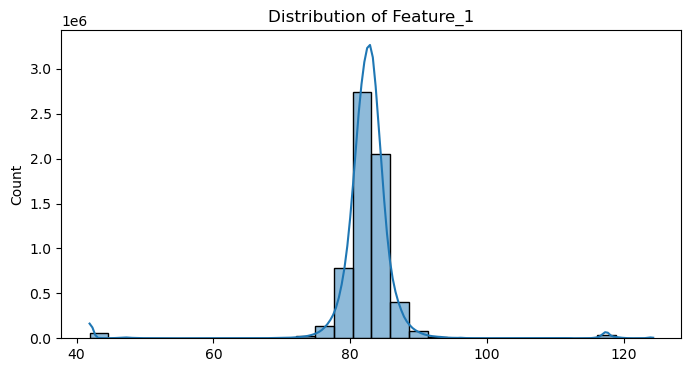

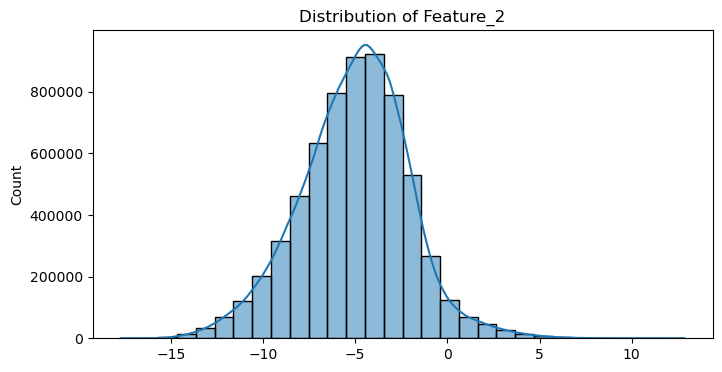

In [ ]:
# EDA Processing
for name, df in dfs.items():
    print(f"\n EDA for {name} Dataset:\n")

    # Display Summary Statistics First
    print(f" Shape: {df.shape}")
    print(f" Data Types:\n{df.dtypes}")
    print(f" Missing Values:\n{df.isnull().sum()}")
    print(f" Unique Label Values:\n{df['Label'].unique()}")

    # Convert TimeStep to Float
    df["TimeStep"] = df["TimeStep"].astype(float)

    # ---------------------------------
    #  Visualization Starts Here
    # ---------------------------------

    # Feature Distribution Plots (Separate Figures)
    num_features = [col for col in df.columns if "Feature" in col]
    
    print("\n Plotting Feature Distributions...")
    for feature in num_features[:6]:  # First 6 features
        plt.figure(figsize=(8, 4))
        sns.histplot(df[feature], bins=30, kde=True)
        plt.title(f"Distribution of {feature}")
        plt.show()

    # Boxplots to Identify Outliers (Separate Figures)
    print("\n Plotting Boxplots for Outlier Detection...")
    for feature in num_features[:6]:  # First 6 features
        plt.figure(figsize=(6, 4))
        sns.boxplot(y=df[feature])
        plt.title(f"Boxplot of {feature}")
        plt.show()

    # Heatmap of Feature Correlations (Separate Figure)
    print("\n Plotting Correlation Heatmap...")
    plt.figure(figsize=(10, 8))
    correlation_matrix = df[num_features].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Feature Correlation Heatmap")
    plt.show()

    # Pairplot of Selected Features (Separate Figure)
    print("\n Generating Pairplot for Feature Relationships...")
    selected_features = num_features[:4] + ["Label"]  # Select first 4 features and label
    sns.pairplot(df[selected_features], hue="Label", diag_kind="kde")
    plt.show()

    # Free Memory
    del df
    gc.collect()

print("\n EDA Completed Successfully!")